<a href="https://colab.research.google.com/github/uol-mediaprocessing/group-projects-traffic-signs/blob/master/main_traffic-signs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Assisting children while biking

### Gruppe 7: Maximilian Hörnis, Florian Schwarm, Dennis Rupprecht

## Motivation 
- Children are active participants in road traffic
- Traffic signs might not be obvious to them
- Handheld technology device (smartphones etc.) usage is prevalent among children 

## Idea

Recognize and classify traffic signs automatically and display them in
an easy to understand assistive technology for children, without distracting them.

## Tasks
    
- Recognizing and classifiying traffic signs
- Interpretation of images in a way that is
    - a) sufficiently comprehensible for children and
    - b) not distracting.

## Possible Extensions

- Detection of intersections without relying on traffic signs
- Detection of traffic lights and their current position (red, green, yellow)
- Applying the traffic sign classifier to live video (or recordings)
- Integrating the system into a mobile application

## Possible Issues

- Recognizing dirty or occluded signs

- Determining which street a sign refers to and how long it is valid
- Reliable detection of intersections

# Machine Learning

## The dataset

The dataset we are using is a modified version of the German Traffic Sign Recognition Benchmark (GTSRB) dataset [1]. 

[1] http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset

In [ ]:
!wget -c https://www.dropbox.com/s/0wa2tfxxu5chkrk/training_data.zip?dl=1 -O training_data.zip

In [ ]:
import os
import os.path
import zipfile

if not os.path.exists("training_data/"):
    with zipfile.ZipFile("training_data.zip", "r") as zip_ref:
        zip_ref.extractall()

We can take a look at the extracted training data.

In [2]:
!tree -d training_data/

training_data/
├── ahead_or_right_only
├── children_crossing_ahead
├── danger_ahead
├── double_bend
├── keep_left
├── keep_right
├── left_or_ahead_only
├── no_bikes_allowed
├── no_entrance
├── no_entry_vehicles
├── pedestrians_in_road_ahead
├── priority
├── priority_road
├── proceed_ahead
├── road_works
├── stop
├── traffic_signals
├── turn_left_ahead
├── turn_right_ahead
└── yield

20 directories


It consists of 20 categories of traffic signs that have been extracted from the GTSRB dataset. Each image shows exactly one traffic sign, usually roughly at the center of the image. Some of the traffic signs might be partially ocluded, rotated, or facing away from the camera.

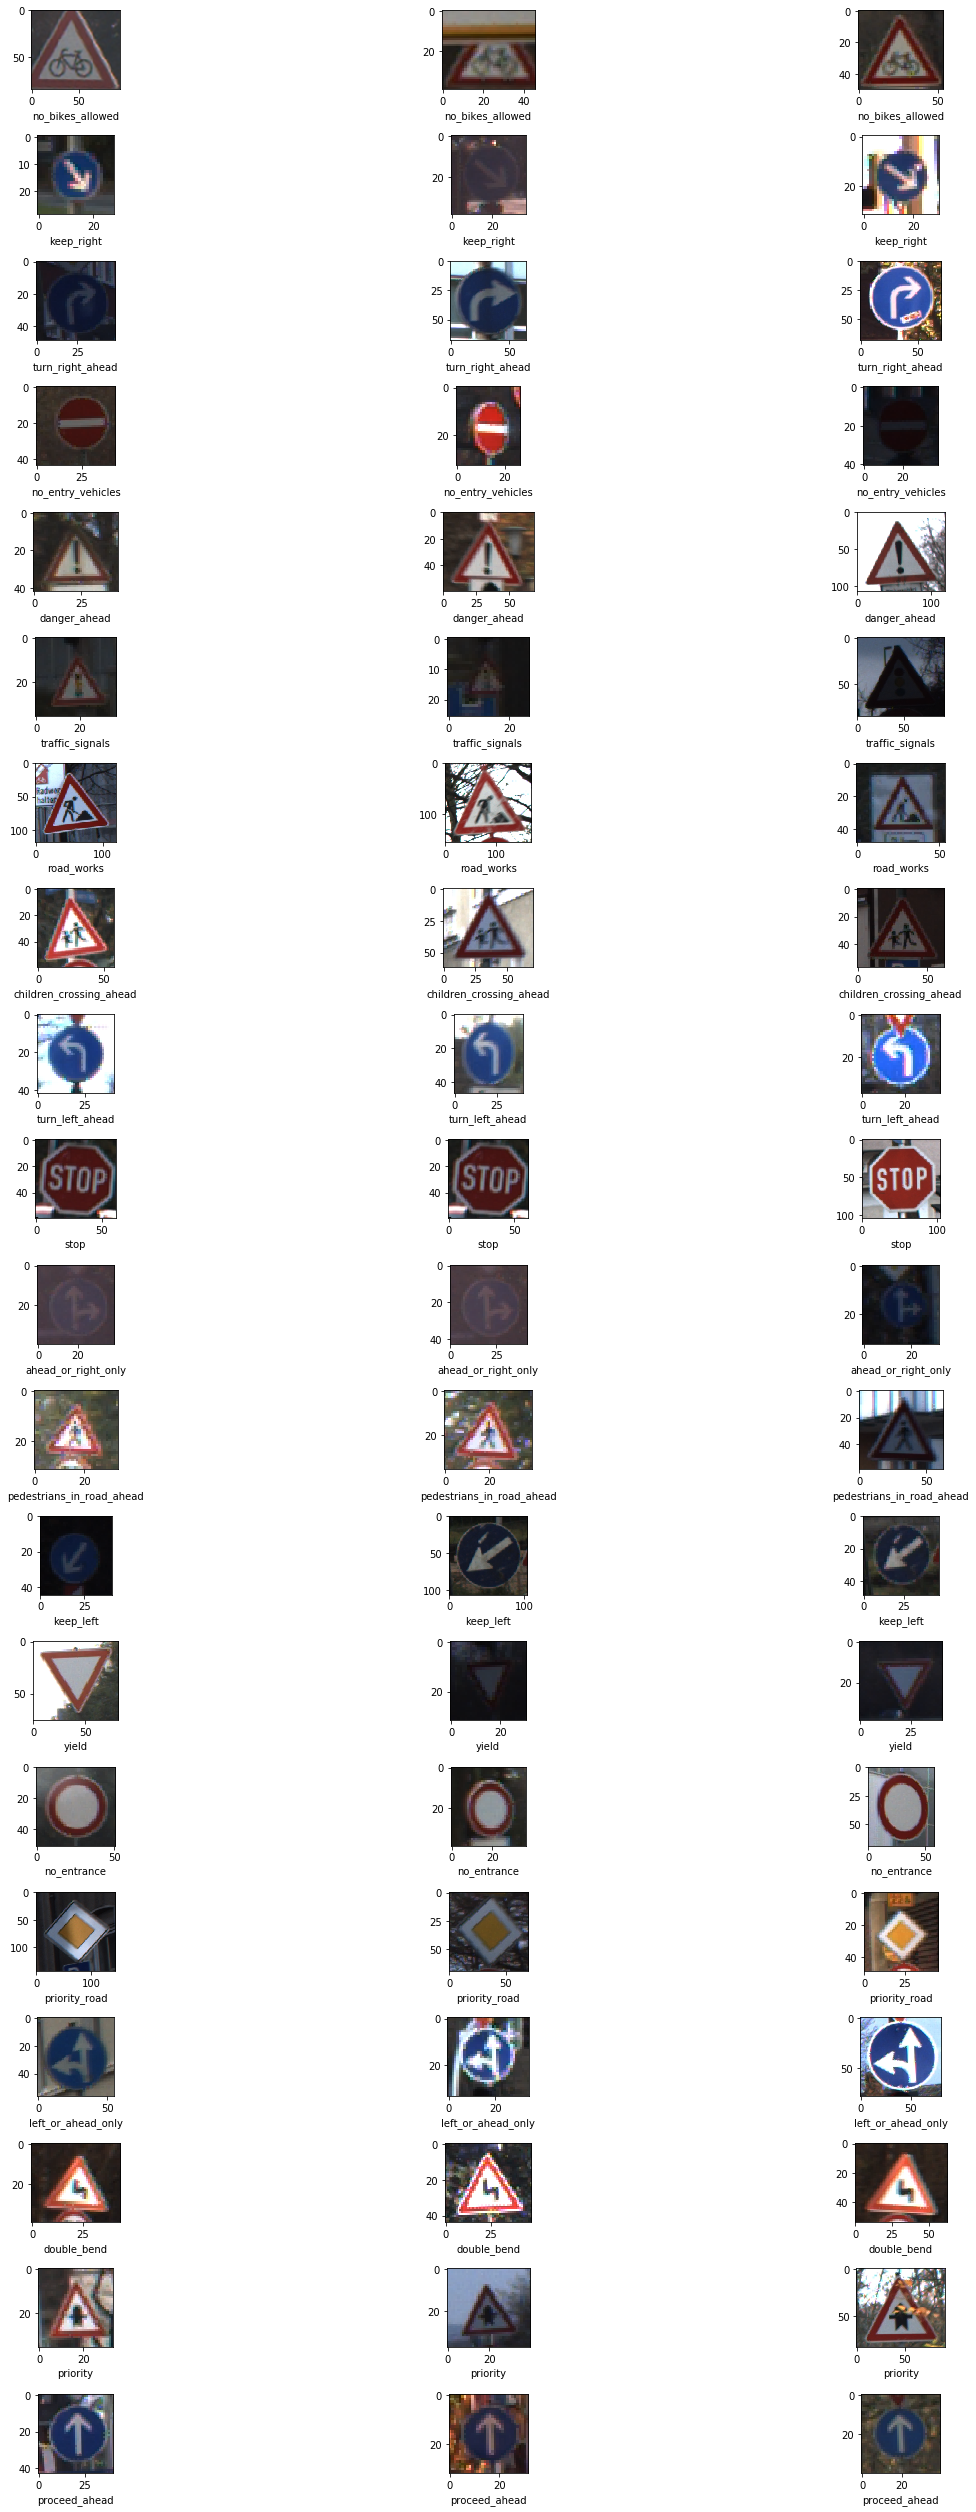

In [3]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import os.path
%matplotlib inline

fig = plt.figure(figsize=(20,35))
for sign_num, sign_type in enumerate(os.listdir("training_data/")):
    sign_path = os.path.join("training_data", sign_type)
    images = np.array(os.listdir(sign_path))
    
    selector = np.random.randint(0, len(sign_path), size=3)
    
    for j, img in enumerate(images[selector]):
        plt.subplot(20, 3, (sign_num * 3) + j + 1)
        plt.xlabel(sign_type)
        plt.imshow(cv.cvtColor(cv.imread(os.path.join(sign_path, img)), cv.COLOR_BGR2RGB))
        
fig.tight_layout()

### TODO: Data Augmentation

Preprocessing the data by augmenting.

In [ ]:
if not True:
    import Augmentor
    p = Augmentor.Pipeline(f"{DATA_PATH}/no_bikes_allowed")

    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.zoom(probability=0.5, min_factor=1.1, max_factor=1.5)

    p.sample(1400 - 270)

The data is processed by loading all images, resizing them to a dimension of 80 by 80 pixels and then storing the images in a NumPy array.

In [4]:
import os
import os.path
import numpy as np
import cv2 as cv

def process_image(fileName):
    img = cv.imread(fileName)
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = cv.resize(img, (80,80))
    return img

DATA_PATH = "training_data/"

X = []
y = []

num_samples = 0

signs = os.listdir(DATA_PATH)

for sign in signs:
    current_samples = num_samples
    
    sign_path = os.path.join(DATA_PATH, sign)
    
    for file in os.listdir(sign_path):
        if not file.endswith(".png"):
            continue
        
        img = process_image(os.path.join(sign_path, file))
        
        X.append(img)
        y.append(signs.index(sign))
        num_samples += 1

    print(f"Read {num_samples - current_samples} samples for {sign}.")

X = np.array(X)
y = np.array(y)

print(f"Number of Samples: {num_samples}")

Read 1400 samples for no_bikes_allowed.
Read 2070 samples for keep_right.
Read 689 samples for turn_right_ahead.
Read 1110 samples for no_entry_vehicles.
Read 1200 samples for danger_ahead.
Read 600 samples for traffic_signals.
Read 1500 samples for road_works.
Read 540 samples for children_crossing_ahead.
Read 420 samples for turn_left_ahead.
Read 1400 samples for stop.
Read 390 samples for ahead_or_right_only.
Read 240 samples for pedestrians_in_road_ahead.
Read 300 samples for keep_left.
Read 2160 samples for yield.
Read 630 samples for no_entrance.
Read 2100 samples for priority_road.
Read 210 samples for left_or_ahead_only.
Read 330 samples for double_bend.
Read 1400 samples for priority.
Read 1200 samples for proceed_ahead.
Number of Samples: 19889


We split the dataset into a training and test set using a 75/25 split (the default setting in train_test_split).

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

## Extracting image features and learning using a support vector machine

Our first approach to classifiying the traffic sign images, is using a support vector machine [0] classifier. In order to do that, we first compute a feature vector for each image by computing Histogram of Oriented Gradients (HOG) [1] features for each image.

[0] James, Gareth, Daniela Witten, Trevor Hastie, and Robert Tibshirani, eds. An Introduction to Statistical Learning: With Applications in R. Springer Texts in Statistics 103. New York: Springer, 2013.

[1] https://en.wikipedia.org/wiki/Histogram_of_oriented_gradients

In [ ]:
import skimage.feature

X_train_hog = np.array([skimage.feature.hog(img) for img in X_train])
X_test_hog = np.array([skimage.feature.hog(img) for img in X_test])

After the conversion the training set now consists of *n* feature vectors, each with a size of 5184 predictors:

In [ ]:
X_train_hog.shape

We now have converted from the original high-dimensional space of dimension `19200 (= 80 * 80 * 3)` to a 5184-dimensional space, which is much more anemable to analysis by a statistical learning algorithm.

We can now use the `SGDClassifier` provided by scikit-learn, which implements a support vector machine trained using stochastic gradient descent (SGD).

In [ ]:
from sklearn import linear_model

clf = linear_model.SGDClassifier(max_iter=100, tol=1e-3, n_jobs=-1)

We can now fit the classifier to the training set of HOG feature vectors.

In [ ]:
clf.fit(X_train_hog, y_train)

We can now compute the training and test accuracy of our model:

In [ ]:
print(f"Training accuracy: {clf.score(X_train_hog, y_train)}")
print(f"Test accuracy: {clf.score(X_test_hog, y_test)}")

## Deep Learning

In [ ]:
from tensorflow.keras import models, layers, optimizers
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import to_categorical

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(80, 80, 3))

In [ ]:
model = models.Sequential()

model.add(layers.Conv2D(32, (3, 3), input_shape=(80, 80, 3)))
model.add(layers.MaxPool2D((2, 2)))

model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.MaxPool2D((2, 2)))

model.add(layers.Conv2D(128, (3, 3)))
model.add(layers.MaxPool2D((2, 2)))

model.add(layers.Flatten())

model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(20, activation='softmax'))

In [ ]:
model.summary()

In [ ]:
model.compile(loss='categorical_crossentropy', 
              optimizer='rmsprop',
              metrics=['acc'])

In [ ]:
model.fit(X_train.astype('float32') / 255.0, to_categorical(y_train), validation_split=0.2, epochs=20)

In [ ]:
model.evaluate(X_test.astype('float32') / 255.0, to_categorical(y_test))

### Running on mobile devices

In [ ]:
import tensorflow
converter = tensorflow.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
f = open("traffic_sign_model.tflite", "w+b")
f.write(tflite_model)
f.close()

In [ ]:
interpreter = tensorflow.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the TensorFlow Lite model on random input data.
interpreter.set_tensor(input_details[0]['index'], [X_train[1300].astype('float32') / 255.0])

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
interpreter.get_tensor(output_details[0]['index'])